## Background

In this notebook, I'll walk through a modified algorithm (suggested by Claude) to calculate the aspect ratio of letters in a text image. The aspect ratio of text in this case corresponds to the ratio of the width to height of a letter. Strictly speaking, [in typography, the aspect ratio is defined](https://tympanus.net/codrops/css_reference/font-size-adjust/#:~:text=Using%20the%20height,size%20(its%20height).) as the ratio of the letter height to the x-height (lowercase letter height) of the font. That is not the definition I'm using here. Instead, I mean aspect ratio of a rectangle (width:height) that bounds a letter.

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., "humanist sans," "grotesque sans," "script," and "display"). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my **TypefaceClassifier** project series.

In [1]:
#| code-fold: true
#| code-summary: "Show imports"

import cv2
import numpy as np, pandas as pd

## Loading the Data

The first image I'll use is that of a display typeface (the font [Bree](https://fonts.adobe.com/fonts/bree)) with a font-size of 76px.

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
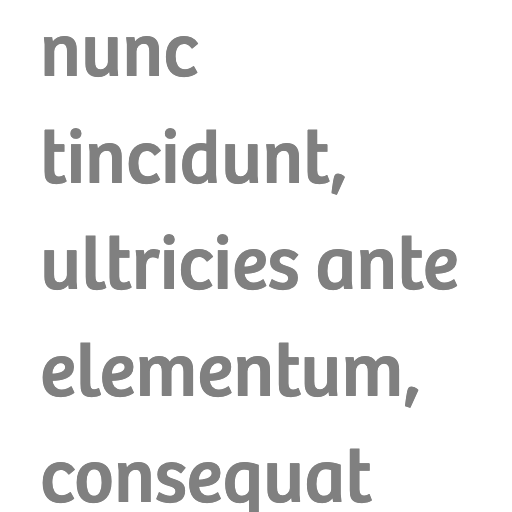

In [15]:
path = 'display-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img

The next step is to convert the image to binary data (`1`=white pixels, `0` = black pixels).

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
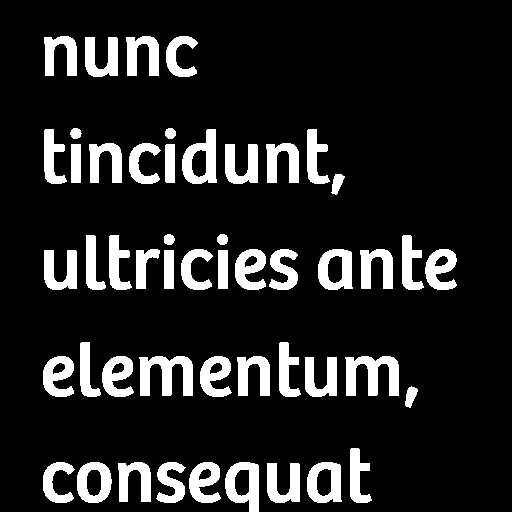

In [16]:
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Finding Letter Contours

Next, we get the **contours** which are defined in the OpenCV docs as:

> a curve joining all the continuous points (along the boundary), having same color or intensity

It makes sense why we converted the image to binary data since that makes the letters all have the same color (white pixels or `1`). The `contours` are outlines of the letters:

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
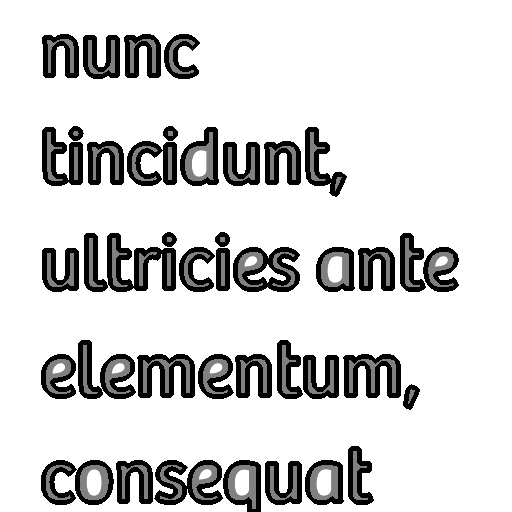

In [17]:
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 3)

## Calculating the Aspect Ratio for Each Letter

Finally, we can calculate the aspect ratio of a letter by creating a bounding box around it. The width and height of the bounding box are used to calculate the aspect ratio $\frac{\text{width}}{\text{height}}$

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
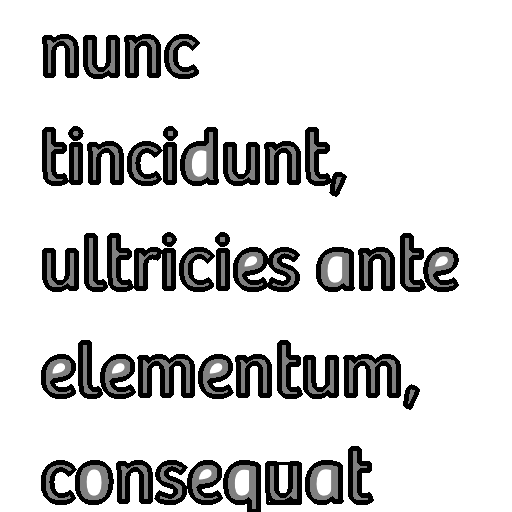

In [18]:
x, y, w, h = cv2.boundingRect(contours[0]) # position, width and height of bounding box
cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2) # bounding box around "u" in "consequat"

In [19]:
# aspect ratio of the "u" in "consequat"
w, h, w/h

(33, 40, 0.825)

## Calculating the Average Aspect Ratio for All Letters

I can put the above contour-to-bounding-box code in a loop over all contours and calculate the average aspect ratio of the letters in the image:

In [16]:
aspect_ratios = []

In [17]:
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  if w > 5 and h > 5:  # filter out punctuation or noise
    aspect_ratios.append(w / h)

In [18]:
np.mean(aspect_ratios), np.median(aspect_ratios)

(0.7164317414293024, 0.7804878048780488)

## Calculating Aspect Ratio for Different Images

I'll wrap that code in a function and apply it to different images of the same font and different fonts.

In [19]:
#| code-fold: true
#| code-summary: "Show the aspect ratio function"

def aspect_ratio(path):
    # Read the image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    aspect_ratios = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 5 and h > 5:  # Filter out very small contours
            aspect_ratios.append(w / h)

    averages = np.mean(aspect_ratios), np.median(aspect_ratios) if aspect_ratios else 0
    return averages

In [55]:
#| code-fold: true
#| code-summary: "Show aspect ratios calcs"

aspect_ratios = []
font_szs = [8, 18, 24, 36, 76, 240, 330, 420]

for typeface in ['display', 'serif']:
  for sz in font_szs:
    aspect_ratios.append((typeface, sz, *aspect_ratio(f"{typeface}-{sz}px.png")))

In [56]:
# Create DataFrame
df = pd.DataFrame(aspect_ratios, columns=['typeface', 'font_size', 'mean_ratio', 'median_ratio'])

The median aspect ratio becomes an outlier at very small (8px) and very large (240px) font sizes.

In [68]:
df

,typeface,font_size,mean_ratio,median_ratio
0,display,8,1.715923,1.500000
1,display,18,0.815149,0.800000
2,display,24,0.745288,0.769231
3,display,36,0.711960,0.750000
4,display,76,0.716432,0.780488
5,display,240,1.684231,1.263158
6,display,330,0.685398,0.823529
7,display,420,0.829781,0.829781
8,serif,8,2.473861,2.401786
9,serif,18,1.084338,1.000000


The median ratio is also more consistent (smaller standard deviation) than the mean ratio (which makes sense as its more robust).

In [67]:
df.groupby('typeface')[['mean_ratio', 'median_ratio']].describe().T

typeface             display     serif
mean_ratio   count  8.000000  8.000000
             mean   0.988020  1.285115
             std    0.442387  0.679100
             min    0.685398  0.838929
             25%    0.715314  0.892189
             50%    0.780219  0.920283
             75%    1.043393  1.382662
             max    1.715923  2.473861
median_ratio count  8.000000  8.000000
             mean   0.939523  1.065642
             std    0.281336  0.544326
             min    0.750000  0.759848
             25%    0.777674  0.846491
             50%    0.811765  0.885101
             75%    0.938125  0.931818
             max    1.500000  2.401786

A tighter font size range (18px to 76 px) yields a more stable median aspect ratio. Here you can see that the `display` text consistently has narrower letters than the `serif` text.

In [66]:
df.query("font_size >= 18 and font_size <= 76").groupby('typeface')['median_ratio'].describe().T

typeface,display,serif
count,4.000000,4.000000
mean,0.774930,0.900884
std,0.020924,0.073112
min,0.750000,0.833333
25%,0.764423,0.854167
50%,0.774859,0.885101
75%,0.785366,0.931818
max,0.800000,1.000000


## Final Thoughts

The non-ML side of computer vision—an area I’m quite new to—continues to surprise me with algorithms that fit surprisingly well into my niche use case: classifying typefaces from text images. Just like with the [x-height to cap-height ratio algorithm](https://vishalbakshi.github.io/blog/posts/2024-08-12-typefaceclassifier-x-to-cap-height/), calculating aspect ratios works best within a specific range of font sizes, as very small or large sizes can cause issues like cropped text or blurry binarized images. I still have several more algorithms to explore as I work toward building a (likely multi-pronged) non-ML baseline for this classification task, and I’ll be covering each in future blog posts.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).